In [1]:
import numpy as np
import pandas as pd
from interactions_data import ExplicitDataset
from interactions_model import EmbeddingNet, find_lr, fit_model
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
import CLR as CLR
import OneCycle as OneCycle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
path = '../data/movielens-small/'
train = ExplicitDataset(csv_file=path+'train.csv')
test = ExplicitDataset(csv_file=path+'test.csv')

In [4]:
print("Training samples: ", 
      len(train),
      "\nTesting samples: ",
      len(test))

Training samples:  75627 
Testing samples:  25209


In [5]:
train.df.head()

,userId,movieId,rating
0,30,56,4.0
1,88,5857,3.0
2,104,726,4.0
3,181,1033,3.5
4,26,1945,5.0


In [6]:
test.df.head()

,userId,movieId,rating
0,473,5281,3.5
1,20,2795,4.0
2,464,1745,4.0
3,589,6261,4.0
4,39,156,1.0


In [9]:
print("Users in train set:", train.df.userId.nunique())
print("Min:", min(train.df.userId.unique()), 
      "Max:", max(train.df.userId.unique()), "\n")
print("Users in test set:", test.df.userId.nunique())
print("Min:", min(test.df.userId.unique()), 
      "Max:", max(test.df.userId.unique()))

Users in train set: 610
Min: 0 Max: 609 

Users in test set: 610
Min: 0 Max: 609


In [10]:
print("Items in train set:", train.df.movieId.nunique())
print("Min:", min(train.df.movieId.unique()), 
      "Max:", max(train.df.movieId.unique()), "\n")
print("Items in test set:", test.df.movieId.nunique())
print("Min:", min(test.df.movieId.unique()), 
      "Max:", max(test.df.movieId.unique()))

Items in train set: 7481
Min: 0 Max: 9724 

Items in test set: 5007
Min: 0 Max: 9719


In [7]:
n_users = max(max(train.df.userId.unique()), max(test.df.userId.unique()))
n_items = max(max(train.df.movieId.unique()), max(test.df.movieId.unique()))
max_score = max(train.df.rating)
min_score = min(train.df.rating)
epoch = 10
bs = 128

In [11]:
train_loader = DataLoader(dataset=train,
                          batch_size=bs,
                          shuffle=False)

test_loader = DataLoader(dataset=test,
                         batch_size=bs,
                         shuffle=False)

In [12]:
# create the model
model = EmbeddingNet(10, n_users, n_items, min_score, max_score).cuda()

# show its parameters
model

EmbeddingNet(
  (u): Embedding(609, 10)
  (i): Embedding(9724, 10)
  (lin1): Linear(in_features=20, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
  (drop1): Dropout(p=0.05)
  (drop2): Dropout(p=0.15)
)

## Learning rate finder

In [13]:
# define the optimizer and loss criterion
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters())
criterion=nn.MSELoss()

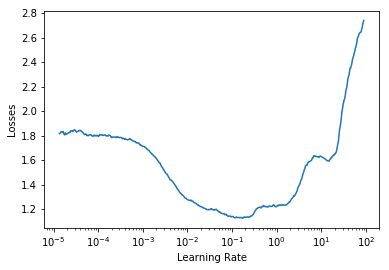

In [14]:
find_lr(model, train_loader, optimizer, criterion)

In [15]:
# create new model with re-initialized weights
model = EmbeddingNet(10, n_users, n_items, min_score, max_score).cuda()

In [16]:
# set the learning rate
lr = 1e-2

## Cyclic Learning Rates

In [17]:
onecycle = OneCycle.OneCycle(nb=int(len(train_loader)*epoch/bs), 
                             max_lr=1e-2,
                             momentum_vals=(0.95, 0.8))

In [17]:
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.95, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters())

## Training

In [18]:
fit_model(epochs=10, 
          model=model, 
          optimizer=optimizer,
          criterion=criterion,
          train=train_loader, 
          test=test_loader)


Training Loss: 1.295.. 
Test Loss: 1.087..  Epoch: 1/10.. 



Training Loss: 1.115.. 
Test Loss: 1.086..  Epoch: 2/10.. 



Training Loss: 1.108.. 
Test Loss: 1.085..  Epoch: 3/10.. 



Training Loss: 1.103.. 
Test Loss: 1.085..  Epoch: 4/10.. 



Training Loss: 1.099.. 
Test Loss: 1.085..  Epoch: 5/10.. 



Training Loss: 1.096.. 
Test Loss: 1.085..  Epoch: 6/10.. 



Training Loss: 1.093.. 
Test Loss: 1.085..  Epoch: 7/10.. 



Training Loss: 1.092.. 
Test Loss: 1.085..  Epoch: 8/10.. 



Training Loss: 1.091.. 
Test Loss: 1.085..  Epoch: 9/10.. 



Training Loss: 1.090.. 
Test Loss: 1.085..  Epoch: 10/10.. 


In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

NameError: name 'train_losses' is not defined

In [27]:
model.eval()

dataiter = iter(test_loader)

In [47]:
users, items, ratings = dataiter.next()

In [48]:
with torch.no_grad():
    output = model(users, items).view(bs).cpu().numpy()

ratings = ratings.cpu().numpy()

In [49]:
mse = np.mean((ratings - output)**2)

In [50]:
mse

0.81329316